In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow as CV

In [ ]:
import cv2
import numpy as np

def extract_lanes(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blur, 50, 150)

    # Define region of interest (ROI)
    height, width = edges.shape[:2]
    roi_vertices = [(0, height), (width/2, height/2), (width, height)]
    roi_mask = np.zeros_like(edges)
    cv2.fillPoly(roi_mask, np.array([roi_vertices], dtype=np.int32), 255)
    masked_edges = cv2.bitwise_and(edges, roi_mask)

    # Apply Hough transform
    lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=100, maxLineGap=50)

    # Filter and average lines
    left_lines, right_lines = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1)
        if slope < -0.5:
            left_lines.append(line)
        elif slope > 0.5:
            right_lines.append(line)

    left_lane = average_lines(left_lines)
    right_lane = average_lines(right_lines)

    # Draw lanes on a blank image
    lane_image = np.zeros_like(image)
    draw_lane_lines(lane_image, left_lane)
    draw_lane_lines(lane_image, right_lane)

    # Overlay lanes on the original image
    result = cv2.addWeighted(image, 0.8, lane_image, 1, 0)

    return result

def average_lines(lines):
    if len(lines) == 0:
        return None

    averaged_line = np.mean(lines, axis=0, dtype=np.int32)
    x1, y1, x2, y2 = averaged_line[0]
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1

    return slope, intercept

def draw_lane_lines(image, lane):
    if lane is None:
        return

    height = image.shape[0]
    slope, intercept = lane
    y1 = height
    y2 = int(height * 0.6)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 5)

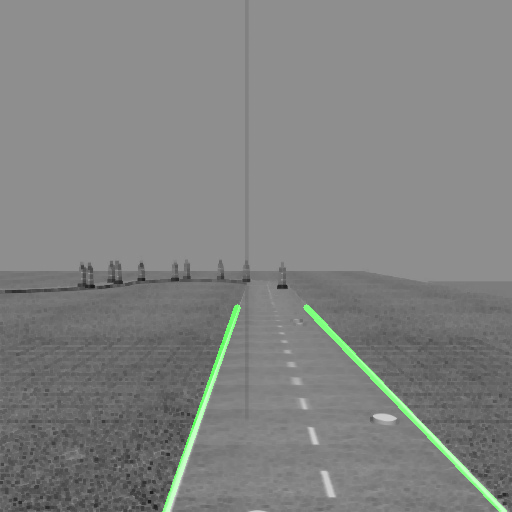

In [ ]:
# Read input image
input_image = cv2.imread('/content/erode.jpg')

# Extract lanes
result_image = extract_lanes(input_image)

# Display the result
CV(result_image)